In [1]:
import FluidSim
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation



MovieWriter ffmpeg unavailable; using Pillow instead.


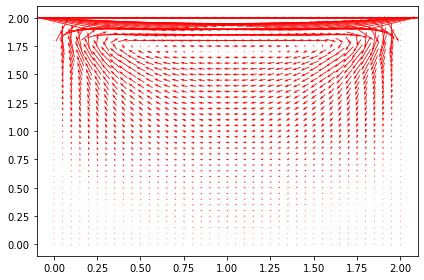

In [5]:
sim = FluidSim.FluidSim(41,41,2,2)
sim.timestep()
fig, ax = plt.subplots(1,1)
Q = ax.quiver(sim.X, sim.Y, sim.u, sim.v, pivot='mid', color='r', units='inches')

def update_quiver(num, Q, X, Y):
    """updates the horizontal and vertical vector components by a
    fixed increment on each frame
    """
    sim.timestep()

    Q.set_UVC(sim.u,sim.v)

    return Q,

# you need to set blit=False, or the first set of arrows never gets
# cleared on subsequent frames
anim = animation.FuncAnimation(fig, update_quiver, fargs=(Q, sim.X, sim.Y),
                               interval=50, blit=False)
anim.save("QuiverPlot.gif")
fig.tight_layout()
plt.show()